# Set-up

In [23]:
import sys
import os
import snapatac2 as snap
import scanpy as sc
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# h5ad path
peaks_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/2024_04_01/atac/regress_out/peak_matrices/peak_mat.h5ad"

# File paths
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
blacklist_path = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/blacklist.bed.gz"
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/2023_11_26/cellid_colors.tsv"

# Output directory
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks"

# Confirm they exist
assert os.path.exists(sample_metadata_path)
assert os.path.exists(blacklist_path)

# Make output directory
os.makedirs(outdir_path, exist_ok=True)

# Load and format data

In [3]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors["SC.EC.1"] = cellid_colors["SC.EC"]
cellid_colors["SC.EC.2"] = "#FFA07A"

In [4]:
# Load peak data
adata_peaks = snap.read(peaks_path, backed=None)
adata_peaks

AnnData object with n_obs × n_vars = 9312 × 286883
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'

In [5]:
# Merge metadata_peaks
bcs = adata_peaks.obs.index.tolist()
adata_peaks_obs = adata_peaks.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_peaks_obs.index = bcs
adata_peaks.obs = adata_peaks_obs
adata_peaks.obs.head()

,sample,log_n_fragment,tsse,leiden_1,annotation,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm11a#AAACAGCCACACAATT-1,dm11a,4.372967,15.601693,3,SC.beta,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACATGCACTTACAG-1,dm11a,4.117205,18.423782,8,SC.alpha,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACATGCATAGTCAT-1,dm11a,3.494155,28.429752,3,SC.EC.2,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACCAACACAGGATG-1,dm11a,4.007620,20.332907,8,SC.alpha,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACCAACAGCGCTTG-1,dm11a,4.471306,13.948440,5,SC.EC.1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt


In [6]:
# Randomly subset to 1000 cells for testing
adata_test = adata_peaks[np.random.choice(adata_peaks.obs.index, 1000, replace=False), :].copy()
adata_test

AnnData object with n_obs × n_vars = 1000 × 286883
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition'

# (Optional) Tighter QC filters

## TSSE

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


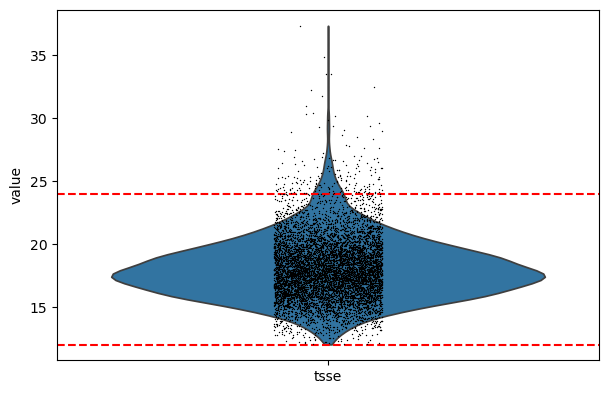

In [ ]:
ax = sc.pl.violin(adata_peaks, keys=["tsse"], show=False)
ax.axhline(12, color="red", linestyle="--")
ax.axhline(24, color="red", linestyle="--")

In [ ]:
# Filter out 
adata_peaks = adata_peaks[(adata_peaks.obs["tsse"] > 12) & (adata_peaks.obs["tsse"] < 24)].copy()
adata_peaks

AnnData object with n_obs × n_vars = 8175 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'spectral1', 'spectral2', 'spectral3', 'spectral4', 'spectral5', 'spectral6', 'spectral7', 'spectral8', 'spectral9', 'spectral10'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue', 'reference_sequences', 'timepoint_colors', 'annotation_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

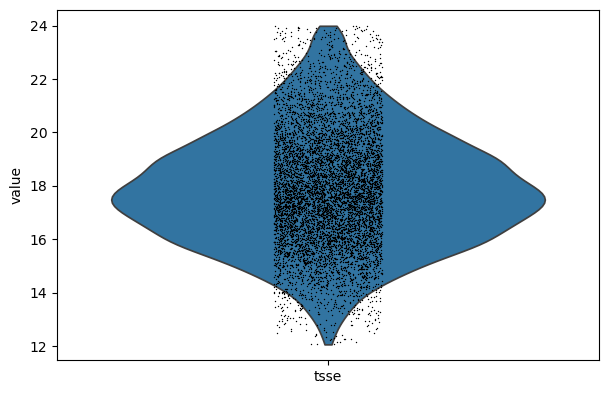

In [ ]:
sc.pl.violin(adata_peaks, keys=["tsse"], show=False)

<Axes: title={'center': 'tsse'}, xlabel='UMAP1', ylabel='UMAP2'>

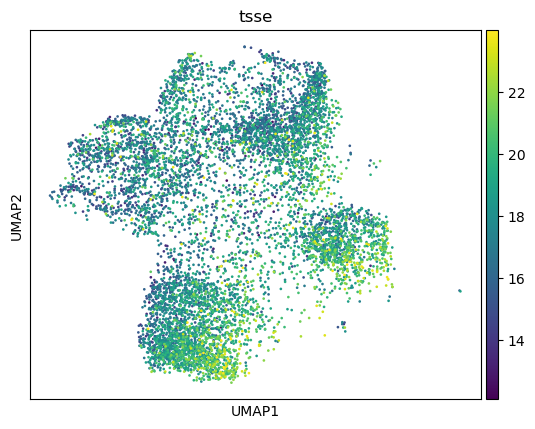

In [ ]:
sc.pl.umap(adata_peaks, color=["tsse"], show=False)

In [ ]:
adata_peaks.obs["annotation"].value_counts(dropna=False)

SC.alpha    2688
SC.beta     2593
SC.EC.1     1671
SC.EC.2     1169
SC.delta      54
Name: annotation, dtype: int64

## Total counts

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


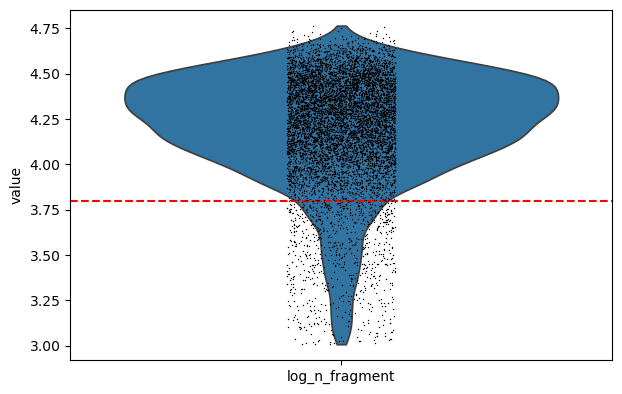

In [ ]:
ax = sc.pl.violin(adata_peaks, keys=["log_n_fragment"], show=False)
ax.axhline(3.8, color="red", linestyle="--")

In [ ]:
# Keep only cells with > 3.8
adata_peaks = adata_peaks[adata_peaks.obs["log_n_fragment"] > 3.8].copy()
adata_peaks

AnnData object with n_obs × n_vars = 7355 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'annotation', 'spectral1', 'spectral2', 'spectral3', 'spectral4', 'spectral5', 'spectral6', 'spectral7', 'spectral8', 'spectral9', 'spectral10'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue', 'reference_sequences', 'timepoint_colors', 'annotation_colors'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

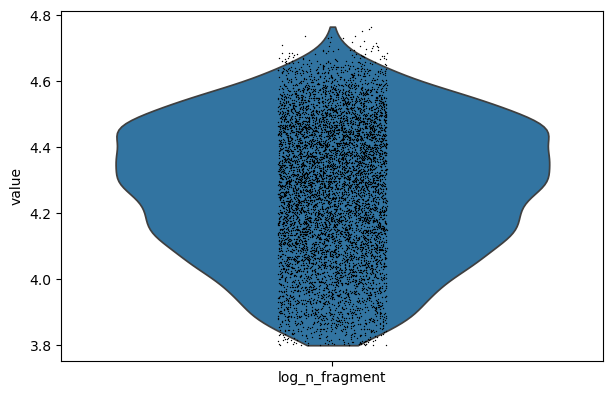

In [ ]:
sc.pl.violin(adata_peaks, keys=["log_n_fragment"], show=False)

In [ ]:
adata_peaks.obs["annotation"].value_counts(dropna=False)

SC.alpha    2410
SC.beta     2355
SC.EC.1     1485
SC.EC.2     1058
SC.delta      47
Name: annotation, dtype: int64

<Axes: title={'center': 'log_n_fragment'}, xlabel='UMAP1', ylabel='UMAP2'>

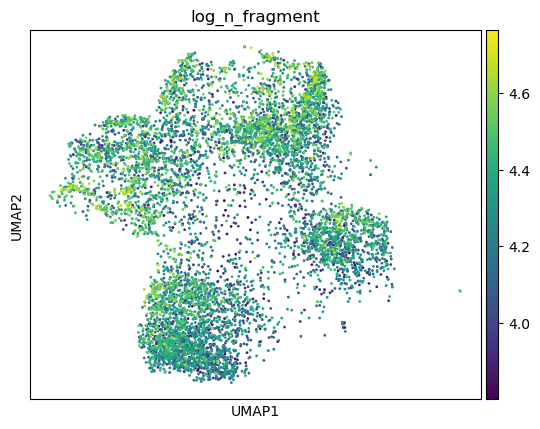

In [ ]:
sc.pl.umap(adata_peaks, color=["log_n_fragment"], show=False)

# Reprocess data with SnapATAC2

In [99]:
for N in [1_000, 10_000, 25_000, 50_000, 100_000, 250_000]:
    snap.pp.select_features(adata_peaks, n_features=N, blacklist=blacklist_path)
    snap.tl.spectral(adata_peaks, random_state=1234)
    if adata_peaks.obsm["X_spectral"].shape[1] > 2:
        snap.tl.umap(adata_peaks, use_dims=list(range(1, adata_peaks.obsm["X_spectral"].shape[1])))
        adata_peaks.obsm[f"X_spectral_{N}"] = adata_peaks.obsm["X_spectral"]
        adata_peaks.obsm[f"X_umap_{N}"] = adata_peaks.obsm["X_umap"]
        del adata_peaks.obsm["X_umap"]
    del adata_peaks.var
    del adata_peaks.obsm["X_spectral"]

2024-03-15 08:16:20 - INFO - Selected 1000 features.
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-03-15 08:16:35 - INFO - Selected 9997 features.
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-03-15 08:17:03 - INFO - Selected 24989 features.
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"

In [ ]:
# Plot the UMAPs with annotations
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) 
axes = axes.flatten()
for i, N in enumerate([1_000, 10_000, 25_000, 50_000, 100_000, 250_000]):
    sc.pl.embedding(basis=f"X_umap_{N}", adata=adata_peaks, color=["annotation"], show=False, ax=axes[i])
    axes[i].set_title(f"N={N}")
#
plt.tight_layout()

In [7]:
# Select all features
snap.pp.select_features(adata_peaks, n_features=10000000, blacklist=blacklist_path)

# Run spectral embedding with all features
snap.tl.spectral(adata_peaks, random_state=1234)

# Run UMAP with all features
snap.tl.umap(adata_peaks, use_dims=list(range(1, adata_peaks.obsm["X_spectral"].shape[1])))

2024-04-17 13:36:29 - INFO - Selected 283879 features.
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/cellar/users/aklie/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


... storing 'sample' as categorical
... storing 'sample_id' as categorical
... storing 'sample_description' as categorical
... storing 'atac_library_id' as categorical
... storing 'rna_library_id' as categorical
... storing 'batch' as categorical
... storing 'condition' as categorical
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


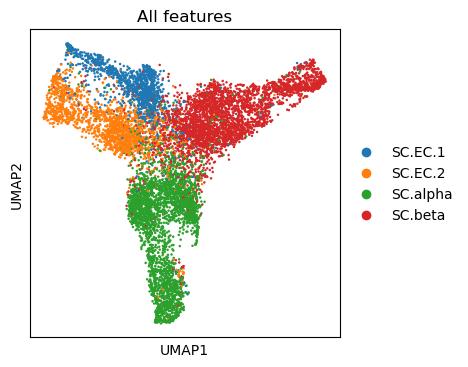

In [8]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_peaks, color=["annotation"], show=False, title="All features")

# Clustering with several resolutions

In [9]:
# Find nearest neighbor graph
snap.pp.knn(adata_peaks, use_rep="X_spectral", use_dims=list(range(1, adata_peaks.obsm["X_spectral"].shape[1])))

In [10]:
# many leidens
snap.tl.leiden(adata_peaks, resolution=0.2, key_added="leiden_0.2", random_state=1234)
snap.tl.leiden(adata_peaks, resolution=0.5, key_added="leiden_0.5", random_state=1234)
snap.tl.leiden(adata_peaks, resolution=0.8, key_added="leiden_0.8", random_state=1234)
snap.tl.leiden(adata_peaks, resolution=1.0, key_added="leiden_1.0", random_state=1234)
snap.tl.leiden(adata_peaks, resolution=1.5, key_added="leiden_1.5", random_state=1234)

In [11]:
# Prep for plotting annotation
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata_peaks.obs["annotation"].unique()}
adata_peaks.obs["annotation"] = adata_peaks.obs["annotation"].astype("category")
adata_peaks.obs["annotation"] = adata_peaks.obs["annotation"].cat.reorder_categories(cellid_colors.keys())
adata_peaks.uns["annotation_colors"] = list(cellid_colors.values())

... storing 'leiden_0.2' as categorical
... storing 'leiden_0.5' as categorical
... storing 'leiden_0.8' as categorical
... storing 'leiden_1.0' as categorical
... storing 'leiden_1.5' as categorical
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/sca

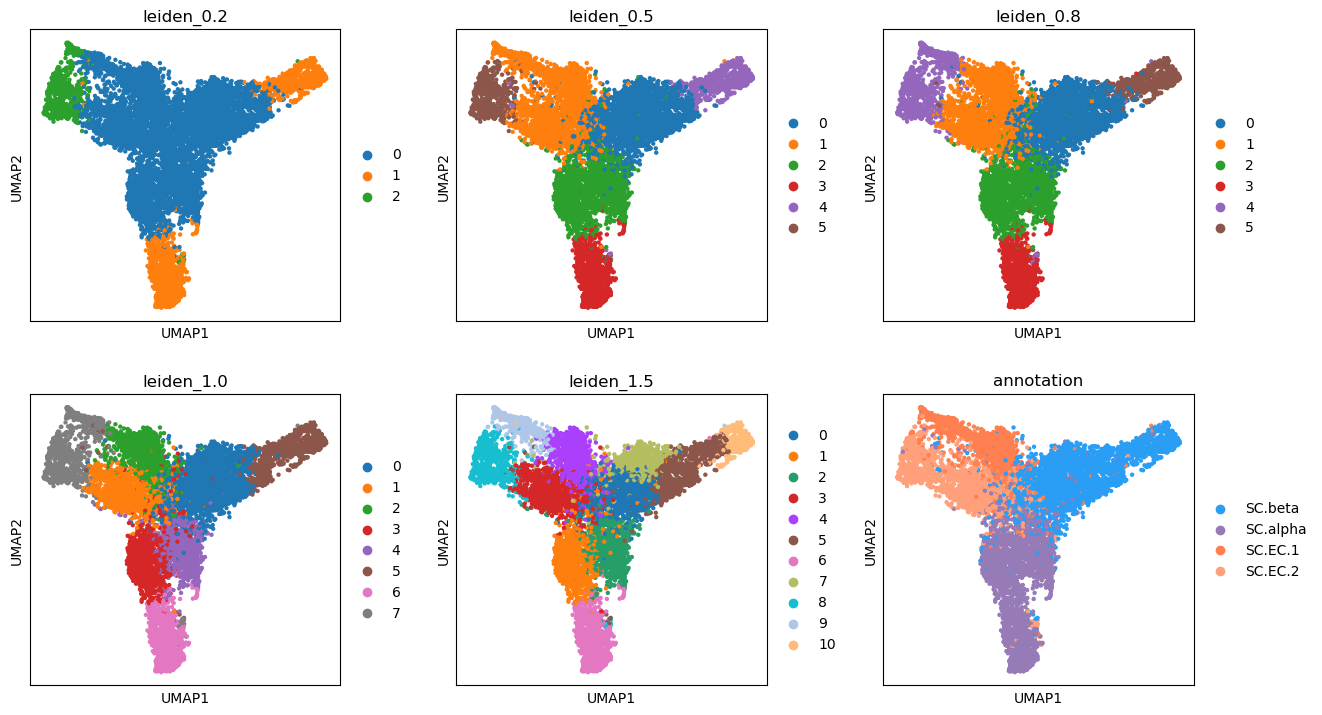

In [12]:
# Check different clustering res
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_peaks, color=["leiden_0.2", "leiden_0.5", "leiden_0.8", "leiden_1.0", "leiden_1.5", "annotation"], ncols=3, s=40, wspace=0.25, show=False)

# Plots

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


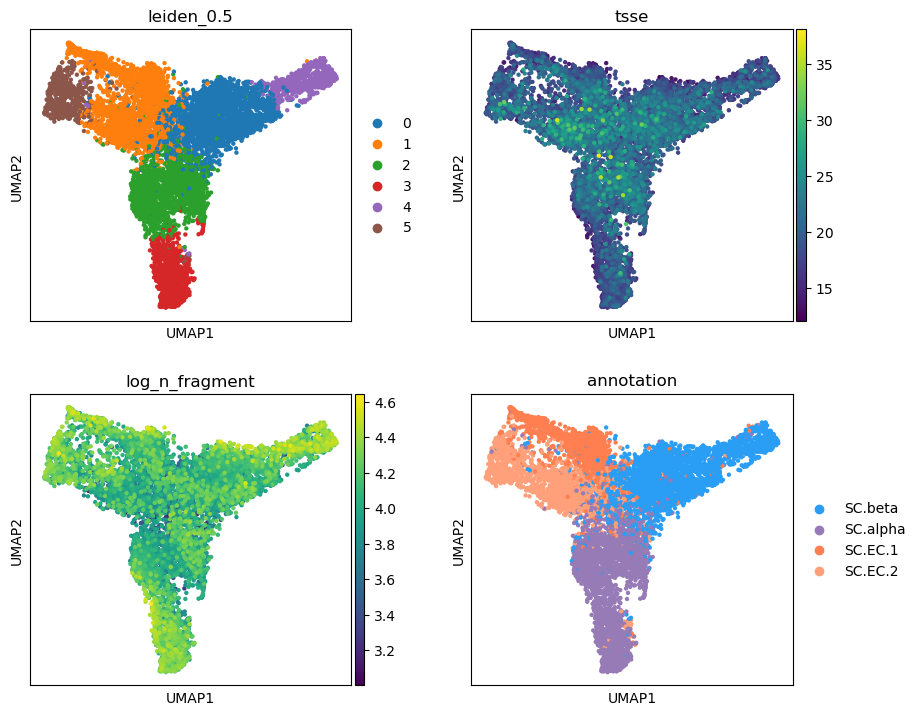

In [13]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_peaks, color=["leiden_0.5", "tsse", "log_n_fragment", "annotation"], ncols=2, wspace=0.25, s=40, show=False)

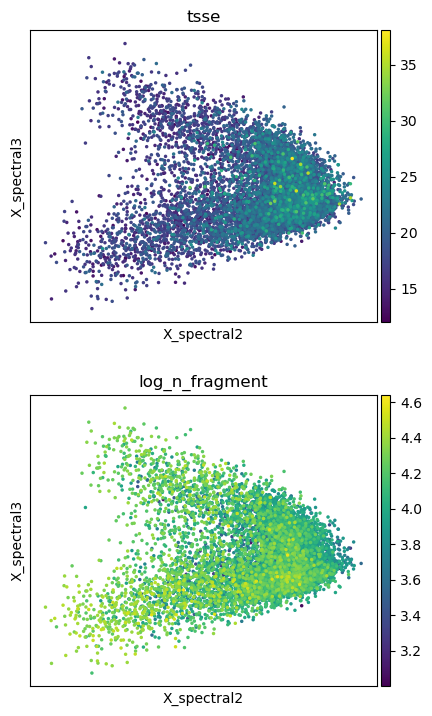

In [14]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(adata_peaks, basis="X_spectral", color=["tsse", "log_n_fragment"], s=25, ncols=1, show=False, components='2,3')

In [15]:
pd.crosstab(adata_peaks.obs["leiden_0.5"], adata_peaks.obs["annotation"])

annotation,SC.beta,SC.alpha,SC.EC.1,SC.EC.2
leiden_0.5,,,,
0,2354,83,52,68
1,91,64,1194,1083
2,86,1941,23,60
3,16,874,7,14
4,718,7,8,4
5,12,6,32,515


Text(0.5, 1.0, 'Annotation proportions in leiden_0.5 clusters')

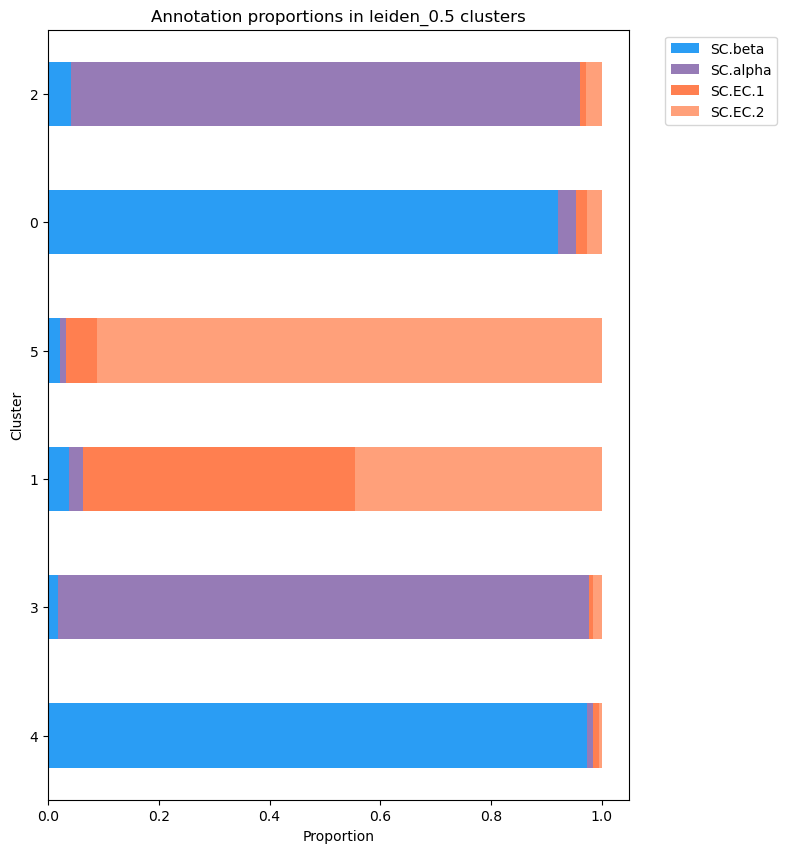

In [16]:
# Stacked barplot of annotation proportions in leiden_0.5 clusters
leiden = adata_peaks.obs["leiden_0.5"].unique().tolist()
annotation_proportions = []
for cluster in leiden:
    proportions = adata_peaks.obs[adata_peaks.obs["leiden_0.5"] == cluster]["annotation"].value_counts(normalize=True)
    proportions.name = cluster
    annotation_proportions.append(proportions)
annotation_proportions = pd.concat(annotation_proportions, axis=1).T
annotation_proportions = annotation_proportions[cellid_colors.keys()]

# Plot horizontal barplot, legend outside to right
fig, ax = plt.subplots(figsize=(7.5, 10))
annotation_proportions.plot.barh(stacked=True, ax=ax, color=cellid_colors.values())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Proportion")
plt.ylabel("Cluster")
plt.title("Annotation proportions in leiden_0.5 clusters")

In [17]:
# Find the majority of each cluster and remove all cells in that cluster not in the majority
barcodes_to_keep = []
for cluster in adata_peaks.obs["leiden_0.5"].unique():
    majority_annotation = adata_peaks.obs[adata_peaks.obs["leiden_0.5"] == cluster]["annotation"].value_counts().idxmax()
    barcodes_to_keep += adata_peaks.obs[(adata_peaks.obs["leiden_0.5"] == cluster) & (adata_peaks.obs["annotation"] == majority_annotation)].index.tolist()
len(barcodes_to_keep)

7596

In [18]:
# Filter to barcodes to keep
adata_filt = adata_peaks[barcodes_to_keep].copy()
adata_filt

AnnData object with n_obs × n_vars = 7596 × 286883
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'leiden_0.2', 'leiden_0.5', 'leiden_0.8', 'leiden_1.0', 'leiden_1.5'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'annotation_colors', 'leiden_0.2_colors', 'leiden_0.5_colors', 'leiden_0.8_colors', 'leiden_1.0_colors', 'leiden_1.5_colors'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

# Presentation plots

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


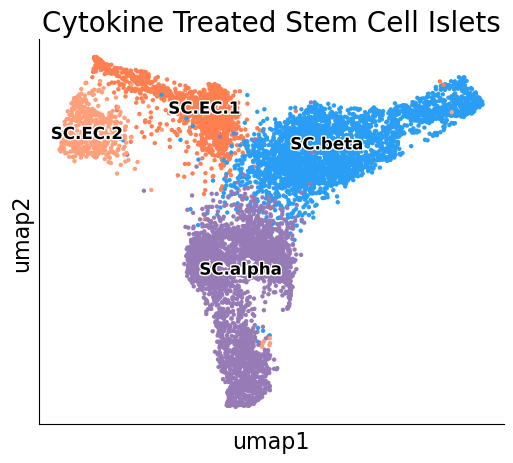

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
sc.pl.umap(
    adata_filt, 
    color=["annotation"], 
    s=40, 
    show=False, 
    frameon=False, 
    legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    title="Cytokine Treated Cell Islets",
    ax=ax
)
ax.axis("on")
ax.tick_params(
    top="off",
    bottom="on",
    left="on",
    right="off",
    labelleft="on",
    labelbottom="off",
)
_ = ax.set_xlabel("umap1", fontsize=16)
_ = ax.set_ylabel("umap2", fontsize=16)
_ = ax.set_title("Cytokine Treated Stem Cell Islets", fontsize=20)


#ax.set(frame_on=False)
# Set bottom and left spines to on
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(outdir_path, "umap_updated_annotation.png"), bbox_inches="tight")

In [25]:
annotation_ordering = [
    "SC.alpha",
    "SC.beta",
    "SC.EC.1",
    "SC.EC.2",
    #"SC.delta"
]

2024-04-17 13:48:12 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-04-17 13:48:12 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


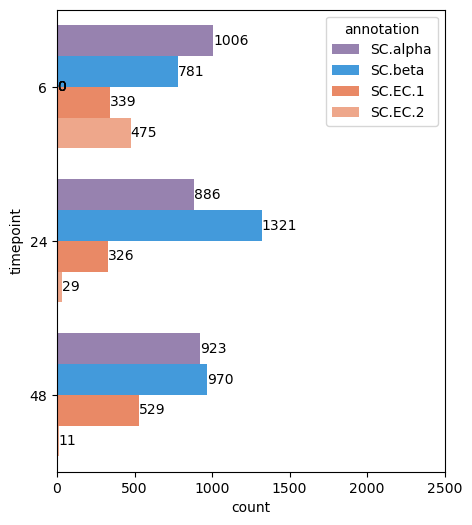

In [26]:
# Horizontal barplot showing number of cells (x) in each sample (y) colored by updated annotation
fig, ax = plt.subplots(1, 1, figsize=(5, 6))

# Plot
sns.countplot(
    y="timepoint",
    data=adata_filt.obs,
    hue="annotation",
    ax=ax,
    palette=cellid_colors,
    hue_order=annotation_ordering
)

ax.set_xlim(0, 2500)

# Add count numbers to right of each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height() / 2, f"{int(width)}", ha="left", va="center")

plt.savefig(os.path.join(outdir_path, "celltype_proportions.png"), bbox_inches="tight")

# Clean and save

## Full anndata

In [27]:
del adata_peaks.uns["annotation_colors"]

KeyError: 'annotation_colors'

In [28]:
adata_peaks.obs.to_csv(os.path.join(outdir_path, "ATAC_cell_metadata.tsv"), sep="\t", index=True)

In [29]:
adata_peaks.write(os.path.join(outdir_path, "ATAC_full.h5ad"))

In [30]:
adata_peaks.obs["annotation"].to_csv(os.path.join(outdir_path, "ATAC_celltype.txt"), sep="\t", index=True, header=False)

## Slim version (keep raw counts, obs, var and X_umap and X_pca)

In [31]:
adata_slim = adata_peaks.copy()

In [32]:
del adata_slim.uns
del adata_slim.obsp

In [34]:
adata_slim.write(os.path.join(outdir_path, "ATAC_slim.h5ad"))

# DONE!

---

# Scratch

## Plot 1st spectral component

In [ ]:
# Plot first spectral embedding against log_n_fragment    
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.embedding(basis="X_spectral", adata=adata_peaks, color="log_n_fragment", show=False)
    #plt.savefig(os.path.join(outdir_path, "spectral_embedding.png"))
    #plt.close()

## Marker peaks

In [ ]:
# Find marker peaks
marker_peaks = snap.tl.marker_regions(adata_peaks, groupby='annotation', pvalue=0.05)

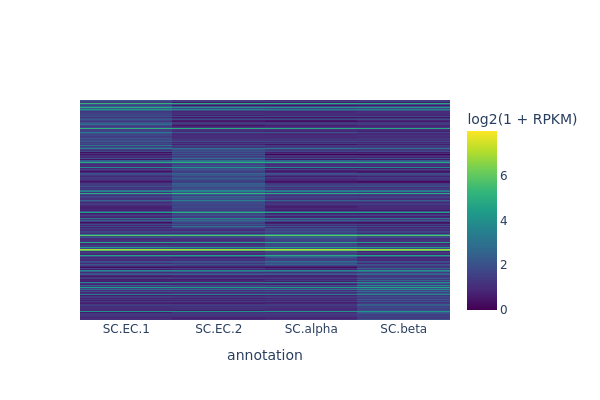

In [ ]:
snap.pl.regions(adata_peaks, groupby='annotation', peaks=marker_peaks, interactive=False)

In [ ]:
marker_peaks

{'SC.EC.1': Index(['chr1:970283-970784', 'chr1:1032384-1032885', 'chr1:1074132-1074633',
        'chr1:1115936-1116437', 'chr1:1281658-1282159', 'chr1:1703846-1704347',
        'chr1:1794949-1795450', 'chr1:1891446-1891947', 'chr1:2467166-2467667',
        'chr1:2489573-2490074',
        ...
        'chrX:153643968-153644469', 'chrX:153902213-153902714',
        'chrX:153953274-153953775', 'chrX:154069729-154070230',
        'chrX:154302733-154303234', 'chrX:154715841-154716342',
        'chrX:155997593-155998094', 'chrY:4483626-4484127',
        'chrY:7274515-7275016', 'chrY:19066622-19067123'],
       dtype='object', length=8759),
 'SC.EC.2': Index(['chr1:843567-844068', 'chr1:1050478-1050979', 'chr1:1168448-1168949',
        'chr1:1250113-1250614', 'chr1:1420611-1421112', 'chr1:1462189-1462690',
        'chr1:1574074-1574575', 'chr1:1697632-1698133', 'chr1:1815441-1815942',
        'chr1:1969008-1969509',
        ...
        'chrX:150848974-150849475', 'chrX:153438442-153438943',
  

In [ ]:
barcodes = np.array(adata_peaks.obs_names)
background = []
for i in np.unique(adata_peaks.obs['annotation']):
    if i != "SC.beta":
        cells = np.random.choice(barcodes[adata_peaks.obs['annotation'] == i], size=30, replace=False)
        background.append(cells)
background = np.concatenate(background)

In [ ]:
beta = adata_peaks[adata_peaks.obs['annotation'] == "SC.beta"].obs_names

In [ ]:
diff_peaks = snap.tl.diff_test(
    adata_peaks,
    cell_group1=beta,
    cell_group2=background,
    direction="positive",
)

2024-03-12 14:38:18 - INFO - Input contains 99020 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2024-03-12 14:38:39 - INFO - Testing 13731 features ...
100%|██████████| 13731/13731 [05:22<00:00, 42.55it/s]


In [ ]:
diff_peaks_pd = diff_peaks.to_pandas()

,feature name,log2(fold_change),p-value,adjusted p-value
0,chr2:121955405-121955906,3.234916,2.381989e-07,0.003271
1,chr11:113574098-113574599,4.397257,1.148677e-06,0.007886
2,chr12:94755644-94756145,4.123755,3.236976e-05,0.056916
3,chr16:51152196-51152697,3.146913,2.951224e-05,0.056916
4,chr2:53515705-53516206,4.055640,2.556627e-05,0.056916
...,...,...,...,...
13726,chr1:165444913-165445414,0.257434,9.996693e-01,0.999815
13727,chr10:63133521-63134022,0.417077,9.996261e-01,0.999815
13728,chr6:82247566-82248067,0.328549,9.996072e-01,0.999815
13729,chr18:63320738-63321239,0.313772,1.000000e+00,1.000000


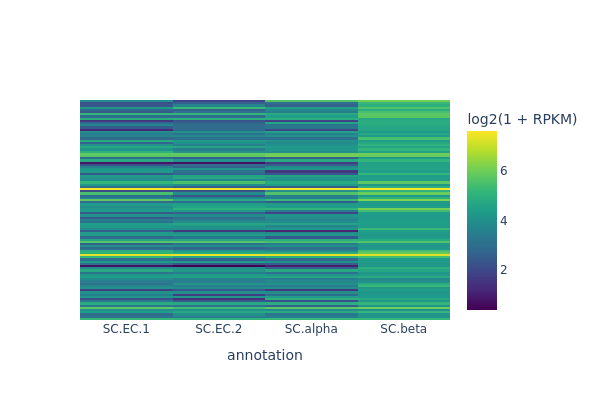

In [ ]:
snap.pl.regions(adata_peaks, groupby='annotation', peaks={ "SC.beta": diff_peaks['feature name'][:100].to_numpy() }, interactive=False)